<a href="https://colab.research.google.com/github/Christian-VH-99/TP3-SOA/blob/main/Ejercicio1_BoxBlur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Introducción**

En el siguiente cuaderno se desarrolla el efecto o filtro "BoxBlur" en una imagen parametrizada, implementado en lenguaje Python de 2 maneras. Primero se vera la la ejecucion en forma secuancial usando solo CPU y luego se vera ina implementacion en fomra paralela con CUDA.

El filtro BoxBlur es un filtro de desenfoque el cual se suele utilizar para eliminar o reducir el ruido en las imagenes. Este filtro tiene la particularidad de que cada pixel de la imagen resultante tiene como valor el promedio de sus pixeles vecinos en la imagen original, logrando asi un difuminado. Este BoxBlur es un cuadro de 3x3.

# **2. Armado del ambiente**



# 2.1 Selección de imagen
Para la poder llevar a cabo el ejercicio tomaremos la direccion web de una imagen con acceso publico a internet, la cual quedara disponible al contexto de ejecucion del cuaderno Colab.

In [ ]:
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://github.com/Christian-VH-99/TP3-SOA/blob/main/Imagenes/imagen04.jpg?raw=true" #@param {type:"string"}
#@markdown ---
!wget {url_imagen} -O imagen.jpg

--2021-11-22 19:36:21--  https://github.com/Christian-VH-99/TP3-SOA/blob/main/Imagenes/imagen04.jpg?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Christian-VH-99/TP3-SOA/raw/main/Imagenes/imagen04.jpg [following]
--2021-11-22 19:36:21--  https://github.com/Christian-VH-99/TP3-SOA/raw/main/Imagenes/imagen04.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Christian-VH-99/TP3-SOA/main/Imagenes/imagen04.jpg [following]
--2021-11-22 19:36:21--  https://raw.githubusercontent.com/Christian-VH-99/TP3-SOA/main/Imagenes/imagen04.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443..

# 2.2 Instalación en el cuaderno el módulo CUDA de Python.

Para poder desarrollar el ejercicio en con CUDA para utilizar GPU y realizar paralelización necesitamos instalar el módulo de CUDA.

In [ ]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 10.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 75 kB 4.3 MB/s 
     |████████████████████████████████| 66 kB 4.1 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627448 sha256=fd48a31c227e5592a064a9ccac60bcf373936c4d5664f1453c295d6f3ef432c3
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.9-py2.py3-none-any.whl size=62370 sha256=9acbb35dea7e0cf82297f7717fa06da08d86ef7a9c862543c751bf7c59b9bc90
  Stored in directory: /root/.cache/pip/wheels/41/b9/6e/94bb014f6484b15ec77e7877f3a227609481ffd98db364504d
Successfully built pycuda pytools


# **3. Desarrollo en CPU**

A continuacion se resuelve el ejercicio desde el punto de vista secuancial.

Imagen del filtro: imagen.jpg -RGB- [435, 331]
Tiempo de conversión de imagen: 5376.251 [ms]
Tiempo Total: 5426.253 [ms]


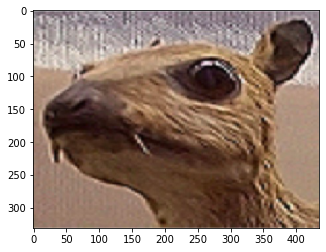

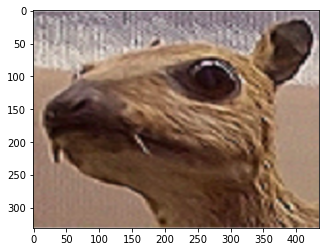

In [91]:
from datetime import datetime

tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = 'imagen.jpg'
image = Image.open(img_nombre)

# Obtengo las dimensiones de la imagen
img_ancho, img_alto = image.size

# Convierto la imagen comprimida en JPEG/PNG a array.
img_origen = numpy.asarray(image)
img_origen = img_origen.astype( numpy.int32() )

# Genero el array resultado (3 pixeles usa RGB * (el tamaño del array)).
img_resultado = numpy.empty_like( img_origen)

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

plt.figure()
imgplot=plt.imshow( img_origen )

tiempo_img = datetime.now()

kernel = 2
# Convierto la imagen a escala de grises

for y  in range( 0, img_alto ):
  for x in range( 0, img_ancho ):
    r_prom=0
    g_prom=0
    b_prom=0

    pixel_R, pixel_G, pixel_B = img_origen[(y-1+img_alto)%img_alto][(x-1+img_ancho)%img_ancho]
    r_prom+=pixel_R
    g_prom+=pixel_G
    b_prom+=pixel_B
    
    pixel_R, pixel_G, pixel_B = img_origen[(y-1+img_alto)%img_alto][x]
    r_prom+=pixel_R
    g_prom+=pixel_G
    b_prom+=pixel_B

    pixel_R, pixel_G, pixel_B = img_origen[(y-1+img_alto)%img_alto][(x+1+img_ancho)%img_ancho]
    r_prom+=pixel_R
    g_prom+=pixel_G
    b_prom+=pixel_B

    pixel_R, pixel_G, pixel_B = img_origen[y][(x-1+img_ancho)%img_ancho]
    r_prom+=pixel_R
    g_prom+=pixel_G
    b_prom+=pixel_B

    pixel_R, pixel_G, pixel_B = img_origen[y][x]
    r_prom+=pixel_R
    g_prom+=pixel_G
    b_prom+=pixel_B

    pixel_R, pixel_G, pixel_B = img_origen[y][(x+1+img_ancho)%img_ancho]
    r_prom+=pixel_R
    g_prom+=pixel_G
    b_prom+=pixel_B

    pixel_R, pixel_G, pixel_B = img_origen[(y+1+img_alto)%img_alto][(x-1+img_ancho)%img_ancho]
    r_prom+=pixel_R
    g_prom+=pixel_G
    b_prom+=pixel_B

    pixel_R, pixel_G, pixel_B = img_origen[(y+1+img_alto)%img_alto][x]
    r_prom+=pixel_R
    g_prom+=pixel_G
    b_prom+=pixel_B

    pixel_R, pixel_G, pixel_B = img_origen[(y+1+img_alto)%img_alto][(x+1+img_ancho)%img_ancho]
    r_prom+=pixel_R
    g_prom+=pixel_G
    b_prom+=pixel_B

    rojo = int(r_prom/9)
    verde = int(g_prom/9)
    azul = int(b_prom/9)
    img_resultado[y][x] = [rojo,verde,azul]


tiempo_img = datetime.now() - tiempo_img

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot = plt.imshow( img_resultado )

tiempo_total = datetime.now() - tiempo_total

print( "Tiempo de conversión de imagen:", tiempo_en_ms( tiempo_img   ), "[ms]" )
print( "Tiempo Total:",                   tiempo_en_ms( tiempo_total ), "[ms]" )

# **4. Desarrollo en GPU**

A continuación se reselve el ejercicio desde el punto de vista optimizado con CUDA.

Imagen del filtro: imagen.jpg -RGB- [435, 331]
Thread: [ 255 , 4  ], Bloque : [ 2 , 83 ]
Total de Thread: [ 510 , 332  ]  =  169320
Tiempo TOTAL:  59.794 [ms]
Tiempo GPU  :  0.164 [ms]


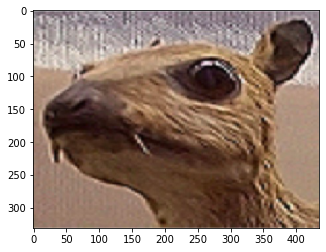

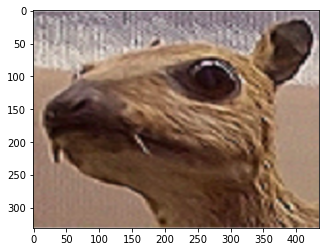

In [90]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# summarize some details about the image 
img_ancho, img_alto  = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_O_cpu = img_O_cpu.astype( numpy.int32() )
img_R_cpu = numpy.empty_like( img_O_cpu)

# Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void kernel_img( int ancho, int alto, int *img_O, int *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  
  int red;
  int green;
  int blue;

  int r_promedio;
  int g_promedio;
  int b_promedio;

  int x;
  int y;


  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho &&  idy < alto  )
  {

    red=0;
    green=0;
    blue=0;

    r_promedio=0;
    g_promedio=0;
    b_promedio=0;

    //obtengo los adyacentes
    x = idx;
    y = idy;

    red += img_O[( ((x-1+ancho)%ancho) + ( ((y-1+alto)%alto)*ancho) )*3 ];  // Componente Rojo del pixel.
    green += img_O[((((x-1+ancho)%ancho) + ( ((y-1+alto)%alto)*ancho))*3)+1];  // Componente Verde del pixel.
    blue += img_O[((((x-1+ancho)%ancho) + ( ((y-1+alto)%alto)*ancho))*3)+2];   // Componente Azul del pixel.

    red += img_O[( x + ( ((y-1+alto)%alto)*ancho) )*3 ];  // Componente Rojo del pixel.
    green += img_O[((x + ( ((y-1+alto)%alto)*ancho))*3)+1];  // Componente Verde del pixel.
    blue += img_O[((x + ( ((y-1+alto)%alto)*ancho))*3)+2];   // Componente Azul del pixel.

    red += img_O[( ((x+1+ancho)%ancho) + ( ((y-1+alto)%alto)*ancho) )*3 ];  // Componente Rojo del pixel.
    green += img_O[((((x+1+ancho)%ancho) + ( ((y-1+alto)%alto)*ancho))*3)+1];  // Componente Verde del pixel.
    blue += img_O[((((x+1+ancho)%ancho) + ( ((y-1+alto)%alto)*ancho))*3)+2];   // Componente Azul del pixel.

    red += img_O[( ((x-1+ancho)%ancho) + (idy*ancho) )*3 ];  // Componente Rojo del pixel.
    green += img_O[((((x-1+ancho)%ancho) + (idy*ancho))*3)+1];  // Componente Verde del pixel.
    blue += img_O[((((x-1+ancho)%ancho) + (idy*ancho))*3)+2];   // Componente Azul del pixel.
    
    red += img_O[( x + (idy*ancho))*3 ];  // Componente Rojo del pixel.
    green += img_O[((x + (idy*ancho))*3)+1];  // Componente Verde del pixel.
    blue += img_O[((x + (idy*ancho))*3)+2];   // Componente Azul del pixel.

    red += img_O[( ((x+1+ancho)%ancho) + (idy*ancho))*3 ];  // Componente Rojo del pixel.
    green += img_O[((((x+1+ancho)%ancho) + (idy*ancho))*3)+1];  // Componente Verde del pixel.
    blue += img_O[((((x+1+ancho)%ancho) + (idy*ancho))*3)+2];   // Componente Azul del pixel.

    red += img_O[( ((x-1+ancho)%ancho) + ( ((y+1+alto)%alto)*ancho) )*3 ];  // Componente Rojo del pixel.
    green += img_O[((((x-1+ancho)%ancho) + ( ((y+1+alto)%alto)*ancho))*3)+1];  // Componente Verde del pixel.
    blue += img_O[((((x-1+ancho)%ancho) + ( ((y+1+alto)%alto)*ancho))*3)+2];   // Componente Azul del pixel.

    red += img_O[(x + ( ((y+1+alto)%alto)*ancho) )*3 ];  // Componente Rojo del pixel.
    green += img_O[((x + ( ((y+1+alto)%alto)*ancho))*3)+1];  // Componente Verde del pixel.
    blue += img_O[((x + ( ((y+1+alto)%alto)*ancho))*3)+2];   // Componente Azul del pixel.

    red += img_O[( ((x+1+ancho)%ancho) + ( ((y+1+alto)%alto)*ancho) )*3 ];  // Componente Rojo del pixel.
    green += img_O[((((x+1+ancho)%ancho) + ( ((y+1+alto)%alto)*ancho))*3)+1];  // Componente Verde del pixel.
    blue += img_O[((((x+1+ancho)%ancho) + ( ((y+1+alto)%alto)*ancho))*3)+2];   // Componente Azul del pixel.


    r_promedio = red/9;
    g_promedio = green/9;
    b_promedio = blue/9;

    // Escribo el color del pixel.
    img_R[(idx+(idy*ancho))*3  ] = r_promedio;
    img_R[(idx+(idy*ancho))*3+1] = g_promedio;
    img_R[(idx+(idy*ancho))*3+2] = b_promedio;
  }
}
""") 

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_img")

tiempo_img = datetime.now()

dim_hilo_x = 255
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 4
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img = datetime.now()

kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_img = datetime.now() - tiempo_img

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

tiempo_total = datetime.now() - tiempo_total

print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )

# **5. Métricas**

